# Mixture Model
> In this example we first generate training data via a mixture model:
> * Step 1: Generate 10 means $b_k \sim \mathcal{N}((1,0),I)$ and labeled BLUE.
> * Step 2: Generate 10 means $o_k \sim \mathcal{N}((0,1),I)$ and labeled ORANGE.
> * Step 3: For each class, we generate 100 observations by:
>   * 1) randomly pick a mean $b \in \{b_0, \dots, b_9\}$ from generated mean set in step 1 and 2
>   * 2) draw an observation from $\mathcal{N}(b, I/5)$

The task is to create a classifier that, based on the coordinates, determines whether the point is ORANGE or BLUE. Of course, the classifier should not be based on then knowledge of how the data was generated.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

GRAY1, GRAY4, PURPLE = '#231F20', '#646369', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'


# Load data

In [2]:
df = pd.read_csv('data/mixture.data')

In [13]:
X_train = df[['x1', 'x2']].values
y_train = df.y.values

# set the known BLUE and ORANGE clusters means
blue_means = np.array([[-0.25343316, 1.7414788], [0.26669318, 0.3712341],
                       [2.09646921, 1.2333642], [-0.06127272, -0.2086791],
                       [2.70354085, 0.5968283], [2.37721198, -1.1864147],
                       [1.05690759, -0.6838939], [0.57888354, -0.0683458],
                       [0.62425213, 0.5987384], [1.67335495, -0.2893159]])
orange_means = np.array([[1.19936869, 0.2484086], [-0.30256110, 0.9454190],
                         [0.05727232, 2.4197271], [1.32932203, 0.8192260],
                         [-0.07938424, 1.6138017], [3.50792673, 1.0529863],
                         [1.61392290, 0.6717378], [1.00753570, 1.3683071],
                         [-0.45462141, 1.0860697], [-1.79801805, 1.9297806]])
all_means = np.vstack((blue_means,orange_means))
# define parameters
prior = np.array([[0.05 for _ in range(10)] for _ in range(2)])
means = np.array([blue_means,orange_means])
cov = np.array([[[0.2,0],[0,0.2]] for _ in range(10)])
covs = np.array([cov, cov])
loss = np.array([[0,1],[1,0]])

In [4]:
df.head()

,x1,x2,y
0,2.526093,0.321050,0
1,0.366954,0.031462,0
2,0.768219,0.717486,0
3,0.693436,0.777194,0
4,-0.019837,0.867254,0


## Function to plot training data

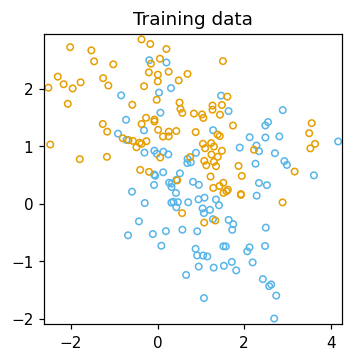

In [5]:
# prepares a plot with a title and circles representing training data
def plot_data(X_plot, y_plot, title=None):
    fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=110)
    ax.scatter(X_plot[:, 0], X_plot[:, 1], s=18, facecolors='none',
               edgecolors=np.array([BLUE, ORANGE])[y_plot])
    ax.set_xlim(X_plot[:,0].min()-0.1, X_plot[:,0].max()+0.1)
    ax.set_ylim(X_plot[:,1].min()-0.1, X_plot[:,1].max()+0.1)
    ax.set_title(title)
    
    return fig, ax

# test it
_, _ = plot_data(X_train, y_train, 'Training data')

In [6]:
# Generate test data according to the means
def gen_mixture_data(means, cov, size=100):
    n = len(means)
    
    idx = np.random.randint(n, size=size)
    Gaussian_nums = []
    
    for k in range(n):
        Gaussian_nums.append(np.random.multivariate_normal(means[k], cov[k], size))
    mixture = []
    pos = [0 for i in range(n)]
    for i in range(size):
        mixture.append(Gaussian_nums[idx[i]][pos[idx[i]]])
        pos[idx[i]] += 1
    
    return np.array(mixture)

X_test = np.vstack((gen_mixture_data(blue_means, cov, 10000), gen_mixture_data(orange_means, cov, 10000)))
y_test = np.hstack((np.array([0 for i in range(10000)]), np.array([1 for i in range(10000)])))

(<Figure size 385x385 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114256b90>)

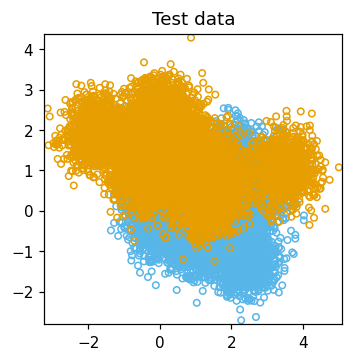

In [7]:
plot_data(X_test, y_test, 'Test data')

# Optimal Bayes classifier

> For a prediction $\hat{y} = f(x)$, the expected predicted error is $EPE(\hat{y}) = \mathbb{E}[L(y, \hat{y})]$. Conditioning on X, we have
$$EPE(\hat{y}) = \mathbb{E}_X \bigg\{\mathbb{E}_{y|X}[L(y, \hat{y}) \mid X]\bigg\} = \mathbb{E}_X \bigg\{ \sum_{k=1}^K L(k, \hat{y}) \Pr(y=k\mid X) \bigg\}.$$
Therefore, in order to minimize the expected predicted error, $\hat{y}(x) = \arg\min_g \{\sum_{k=1}^K L(k, g) \Pr(y=k\mid X=x) \}$. 
> * In the case where all misclassification has losses 1, $\hat{y} =\arg\min_g \{ \sum_{k=1}^K (1-\mathbb{1}\{k=g\}) \Pr(y=k\mid X=x) \} = \arg\max_g \Pr(y=g\mid X=x) \}$, which is the most likely class.  Since $\Pr(y=g \mid X=x) \propto \Pr(X=x \mid y=g) \Pr(y=k)$, we have $\hat{y} = \arg\max_g \bigg\{\log P(x \mid g) + \log P(y=g) \bigg\}.$  
> In real-life we usually do not know the posterior distribution, but rather we estimate it. The Naive Bayes classifier approximates the optimal Bayes classifier by looking at the empirical distribution and by assuming independence of predictors. So the Naive Bayes classifier is not itself optimal, but it approximates the optimal solution. 

> Since we know the distribution from which our data was sampled, we can build the optimal Bayes classifier and calculate the optimal Bayes test error rate as our benchmark. Let's write a classification function that takes samples as an input and produces a vector of predicted classes.



In [8]:
from scipy.stats import multivariate_normal
def compute_posterior(x, means=means, covs=covs, prior_prob=prior):
    '''
        Compute posterior probability for P(y=g|X=x) using distribution of X in each class P(X=x|y=g) and prior distribution P(y=g) 
        -- means[i][j] denotes the mean of the jth Gaussian distribution in class i 
        -- covs[i][j] is an 2d-array denotes the covariance matrix of the jth Gaussian distribution in class i
        -- prior_prob[i][j] denotes the prior distribution of the jth Gaussian distribution in class i. The sum of prior prob should be equal to 1
        -- x is the input to evaluate
        
        Return the posterior for each Gaussian distribution.
    '''
    n = len(means)
    post_prob = [[] for _ in range(n)]
    for i in range(n):
        m = len(means[i])
        for j in range(m):
            post_prob[i].append(multivariate_normal.pdf(x, mean = means[i][j], cov = covs[i][j]) * prior_prob[i][j])
    post_prob = np.array(post_prob)
    post_prob = (post_prob/post_prob.sum(axis=0).sum(axis=0)).T
    
    return post_prob

def optimal_bayes_classifier(x, means=means, covs=covs, prior_prob=prior, loss=loss):
    '''
        Optimal Bayes classifier
        -- means[i][j] denotes the mean of the jth Gaussian distribution in class i 
        -- covs[i][j] is an 2d-array denotes the covariance matrix of the jth Gaussian distribution in class i
        -- prior_prob[i][j] denotes the prior distribution of the jth Gaussian distribution in class i. The sum of prior prob should be equal to 1
        -- loss[i][j] is the loss for classifying true class i to class j
        -- x is the input to evaluate
        
        return the class by optimal bayes rule.
    '''
    
    post_prob = compute_posterior(x, means, covs, prior_prob)
    prob = post_prob.T.sum(axis=1).T
    
    return np.array([np.argmin(np.dot(prob, loss).T,axis=0)]).flatten()

In [9]:
obc = optimal_bayes_classifier(X_test, means, covs, prior, loss=loss)

In [15]:
# Use gaussian mixture class to sanity check results
from sklearn.mixture import GaussianMixture
from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky

def optimal_bayes_classifier_verify(x, means):
    gaussian_mixture_model = GaussianMixture(
        n_components=20,
        covariance_type='spherical',
        means_init=all_means,
        random_state=1
    ).fit(all_means)
    # set known covariances
    gaussian_mixture_model.covariances_ = [1/5]*20
    # it looks like a hack, but GaussianMixture uses precisions_cholesky_
    # for predict_proba method. Because we changed covariances_ we need
    # to recalculate precisions_cholesky_ too.
    gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
        gaussian_mixture_model.covariances_,
        gaussian_mixture_model.covariance_type)

gaussian_mixture_model = GaussianMixture(
    n_components=20,
    covariance_type='spherical',
    means_init=all_means,
    random_state=1
).fit(all_means)
# set known covariances
gaussian_mixture_model.covariances_ = [1/5]*20
# it looks like a hack, but GaussianMixture uses precisions_cholesky_
# for predict_proba method. Because we changed covariances_ we need
# to recalculate precisions_cholesky_ too.
gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
    gaussian_mixture_model.covariances_,
    gaussian_mixture_model.covariance_type)

components_proba = gaussian_mixture_model.predict_proba(X_test)
# first 10 components are BLUE(0), and others are BROWN(1)
blue_proba = np.sum(components_proba[:, :10], axis=1)
brown_proba = np.sum(components_proba[:, 10:], axis=1)
y_hat = 1*(blue_proba < brown_proba)

(obc!=y_hat).sum()

0

## Functions to evaluate model

In [75]:
def model_eval(model_predict):
    d = {}
    d['train_error'] = (model_predict(X_train) != y_train).mean()
    d['test_error'] = (model_predict(X_test) != y_test).mean()
    d['Optimal_bayes_error'] = (optimal_bayes_classifier(X_test) != y_test).mean()

    return d

In [76]:
model_eval(optimal_bayes_classifier)

{'train_error': 0.15, 'test_error': 0.20905, 'Optimal_bayes_error': 0.20905}

## Function to Plot decision boundary

In [114]:
def plot_decision_boundary(X_train, y_train, model_predict):
    fig, ax = plot_data(X_train, y_train)
    (x_low, x_high) = ax.get_xlim()
    (y_low, y_high) = ax.get_ylim()
    # create x, y values
    x_plot = np.linspace(x_low, x_high, int((x_high - x_low)*30))
    y_plot = np.linspace(y_low, y_high, int((y_high - y_low)*30))
    meshgrid = np.transpose([np.tile(x_plot, len(y_plot)), np.repeat(y_plot, len(x_plot))])
    # compute z values and plot contour
    z_bayes = optimal_bayes_classifier(meshgrid)
    z_model = model_predict(meshgrid)
    ax.contour(x_plot, y_plot, z_bayes.reshape(len(y_plot),len(x_plot)), [0.5], colors='red', linewidths=[0.7])
    ax.contour(x_plot, y_plot, z_model.reshape(len(y_plot),len(x_plot)), [0.5], colors=GRAY1, linewidths=[0.7])

    ax.scatter(meshgrid[:,0], meshgrid[:,1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[z_model])
    
    d = model_eval(model_predict)
    ax.text(0.01,0.11,'Train Error: ' + "{:.3f}".format(d['train_error']),transform=ax.transAxes, fontsize=8)
    ax.text(0.01,0.06,'Test Error: ' + "{:.3f}".format(d['test_error']),transform=ax.transAxes, fontsize=8)
    ax.text(0.01,0.01,'Optimal Bayes Error: ' + "{:.3f}".format(d['Optimal_bayes_error']),transform=ax.transAxes, fontsize=8)
    
    return fig, ax, d

Text(0.5, 1.0, 'Optimal Baysian classifier')

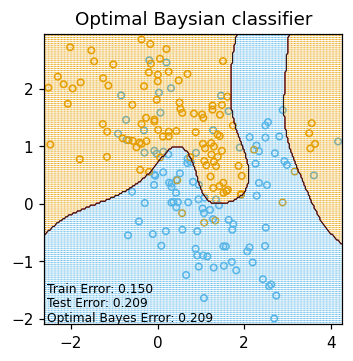

In [115]:
fig, ax, d = plot_decision_boundary(X_train, y_train, optimal_bayes_classifier)
ax.set_title('Optimal Baysian classifier')

# Logistic regression

In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
clf = LogisticRegression().fit(X_train, y_train)

In [99]:
(clf.predict(X_train)!=y_train).mean()

0.27

In [100]:
(clf.predict(X_test)!=y_test).mean()

0.2802

Text(0.5, 1.0, 'Logistic regression')

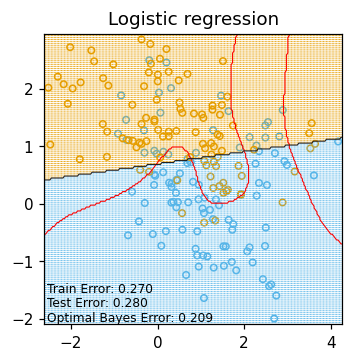

In [117]:
fig, ax, d = plot_decision_boundary(X_train, y_train, clf.predict)
ax.set_title('Logistic regression')

# LDA/QDA/Naive Bayes
> The idea of these approaches is to using training data to estimate/approximate posterier distribution $P(y=k \mid X=x)$. 
> * For LDA/QDA, we assume the distribution of $X$ given $y=k$ follows a multi-variate Gaussian distribution, with mean $\mu_k$ and covariance $\Sigma_k$. For $X \in \mathbb{R}^d$, 
$$ P(X=x \mid y=k) = (2\pi)^{-d/2} |\Sigma_k|^{-1/2} \exp\bigg(-\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1}(x-\mu_k)\bigg).$$
Then $\log P(y=k \mid X=x) = Const - \frac{1}{2} \log(|\Sigma_k|) - \frac{1}{2}(x-\mu_k)^T \Sigma_k^{-1}(x-\mu_k) + \log P(y=k)$. The last term is the prior distribution of the classes, and usually use uniform or class propotions from the training set to estimate.
>  * LDA assumes all $\Sigma_k$ are equal to $\Sigma$, i.e., the Gaussian distribution for each class has the same covariance. In this case, 
$$\hat{y} = \arg\max_k\bigg\{- \frac{1}{2}(x-\mu_k)^T \Sigma^{-1}(x-\mu_k) + \log P(y=k)\bigg\}$$
, where $\mu_k$ is the sample mean of class k and $\Sigma$ can be estimated by unbiased estimates of sample variance. Note that the $x^2$ term in the above formula cancels out for different classes, hence the decision boundary is **linear**.
>  * QDA allows different covariance matrices of Gaussian distribution for different classes.
$$\hat{y} = \arg\max_k\bigg\{- \frac{1}{2} \log(|\Sigma_k|) - \frac{1}{2}(x-\mu_k)^T \Sigma_k^{-1}(x-\mu_k) + \log P(y=k)\bigg\}.$$ Its decision boundary is quadratic.
> * For Naive Bayes, we made a **naive** assumption that each pair of features condition on the class are **independent**. Given an observation $\mathbf{x} = (x_1, \dots, x_p)$, we can apply Bayes rule to estimate the posterier distribution as follows:
\begin{align}
P(y \mid x_1, \dots x_p) & \propto P(\{x_1, \dots, x_p\}\mid y) P(y) \\
& = \Pi_{i=1}^p P(x_i \mid y) P(y).
\end{align}
Therefore, $\hat{y} = \arg\max_y\big\{P(y) \Pi_{i=1}^p P(x_i \mid y) \big\}$, where $P(y)$ is prior distribution of the class y. A class's prior may be calculated by assuming equiprobable classes (i.e., 1 / #classes), or by calculating an estimate for the class probability from the training set (i.e., #samples in the class/ #samples). The distributions of features $P(x_i \mid y)$ are called **event model**, and can be different for different features. Typical choices are
>   * Gaussian model: $x_i \mid y \sim N(\mu_{iy}, \sigma_{iy})$, where $\mu_{iy}, \sigma_{iy}$ are maximum likelihood estimator using training data.
>   * Multinomial model: This is mostly used for document classification problem, where features are the countings of the words.
The multinomial naïve Bayes classifier becomes a linear classifier when expressed in log-space. 
>   * Bernoulli model: $x_i \mid y \sim Bernoulli(p_{iy})$. This is used when features are binary.
> * Gaussian Naive Bayes is equivalent to QDA model that assumes the covariance matrices are diagonal.

In [106]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(X_train,y_train)

Text(0.5, 1.0, 'LDA')

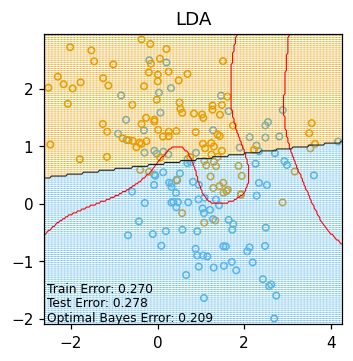

In [118]:
fig, ax, d = plot_decision_boundary(X_train, y_train, lda.predict)
ax.set_title('LDA')

In [108]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis().fit(X_train,y_train)

Text(0.5, 1.0, 'QDA')

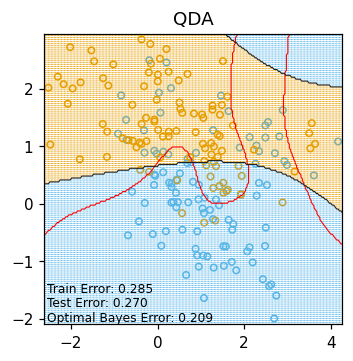

In [119]:
fig, ax, d = plot_decision_boundary(X_train, y_train, qda.predict)
ax.set_title('QDA')

In [111]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train,y_train)

Text(0.5, 1.0, 'Naive Bayes')

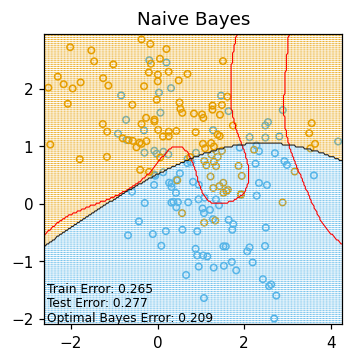

In [120]:
fig, ax, d = plot_decision_boundary(X_train, y_train, gnb.predict)
ax.set_title('Naive Bayes')

# Nearest-Neighbor Methods

In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold

In [158]:
param_grid = {'n_neighbors': [i for i in range(1,50)]}
res = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv = 10, return_train_score = True).fit(X_train, y_train)

In [177]:
res.best_params_

{'n_neighbors': 12}

In [190]:
knn = KNeighborsClassifier(n_neighbors=12).fit(X_train, y_train)

Text(0.5, 1.0, '12 Nearest-Neighbor')

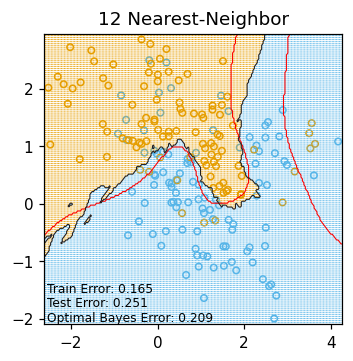

In [192]:
fig, ax, d = plot_decision_boundary(X_train, y_train, knn.predict)
ax.set_title('12 Nearest-Neighbor')

Text(0.5, 1.0, '1 Nearest-Neighbor')

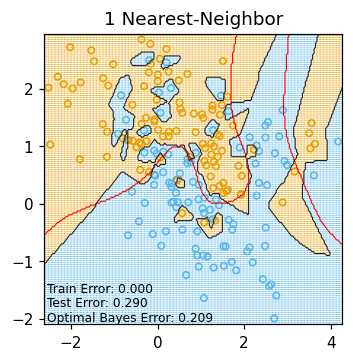

In [193]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
fig, ax, d = plot_decision_boundary(X_train, y_train, knn.predict)
ax.set_title('1 Nearest-Neighbor')